<a href="https://colab.research.google.com/github/apallath/cats_vs_dogs_models/blob/main/cats_vs_dogs_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
import os, shutil
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

In [3]:
# Load subset of Cats v/s Dogs image dataset
train_cats = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/train/cats'
train_dogs = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/train/dogs'
val_cats = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/val/cats'
val_dogs = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/val/dogs'
test_cats = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/test/cats'
test_dogs = '/content/drive/MyDrive/colab_data/cats_vs_dogs_small/test/dogs'

print(len(os.listdir(train_cats)))
print(len(os.listdir(train_dogs)))
print(len(os.listdir(val_cats)))
print(len(os.listdir(val_dogs)))
print(len(os.listdir(test_cats)))
print(len(os.listdir(test_dogs)))

# Use Keras ImageDataGenerator to create train, val, and test datasets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/colab_data/cats_vs_dogs_small/train/',
                                              target_size=(150, 150),
                                              batch_size=20,
                                              class_mode='binary')

val_gen = val_datagen.flow_from_directory('/content/drive/MyDrive/colab_data/cats_vs_dogs_small/val/',
                                              target_size=(150, 150),
                                              batch_size=20,
                                              class_mode='binary')

1000
1000
500
500
500
500
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
model = models.Sequential()

# ResNet50 base
base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model.add(base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Step 1: Freeze conv base, train dense block.

In [5]:
base.trainable = False

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
______________________________________

In [7]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(train_gen,
                    steps_per_epoch=100,  #2000 = 100 * 20
                    epochs=30,
                    validation_data=val_gen,
                    validation_steps=50)  #1000 = 50 * 20

Epoch 1/30
100/100 [==============================] - 30s 236ms/step - loss: 0.2984 - accuracy: 0.8809 - val_loss: 0.1011 - val_accuracy: 0.9620
Epoch 2/30
100/100 [==============================] - 22s 223ms/step - loss: 0.1369 - accuracy: 0.9534 - val_loss: 0.1624 - val_accuracy: 0.9420
Epoch 3/30
100/100 [==============================] - 22s 221ms/step - loss: 0.1166 - accuracy: 0.9559 - val_loss: 0.0623 - val_accuracy: 0.9810
Epoch 4/30
100/100 [==============================] - 22s 222ms/step - loss: 0.1285 - accuracy: 0.9446 - val_loss: 0.0663 - val_accuracy: 0.9710
Epoch 5/30
100/100 [==============================] - 22s 220ms/step - loss: 0.0842 - accuracy: 0.9636 - val_loss: 0.0677 - val_accuracy: 0.9720
Epoch 6/30
100/100 [==============================] - 22s 219ms/step - loss: 0.0926 - accuracy: 0.9711 - val_loss: 0.0829 - val_accuracy: 0.9670
Epoch 7/30
100/100 [==============================] - 22s 219ms/step - loss: 0.0912 - accuracy: 0.9645 - val_loss: 0.0817 - val_ac

In [9]:
model.save('/content/drive/MyDrive/colab_models/cats_vs_dogs_resnet50_dense.h5')

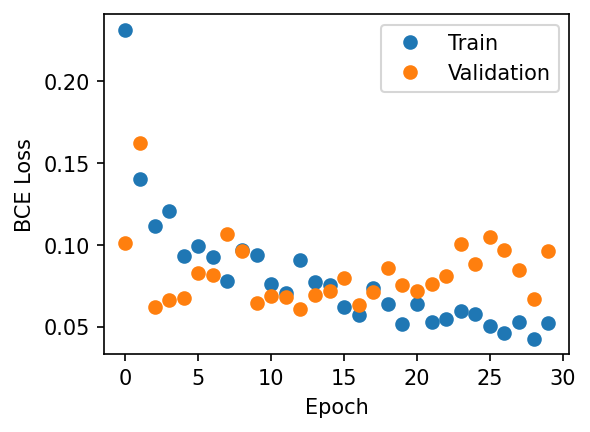

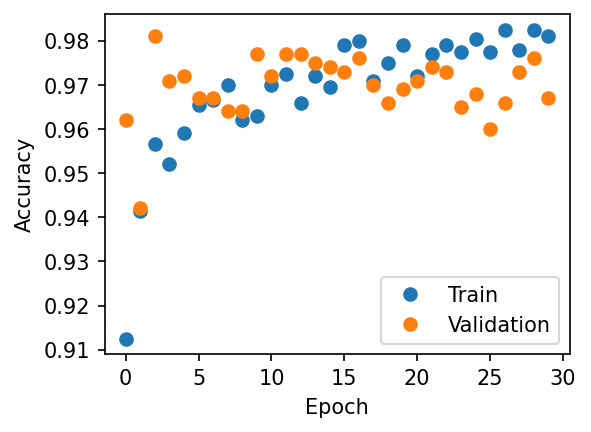

In [10]:
n_epochs = 30

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(range(n_epochs), history.history['loss'], 'o', label="Train")
ax.plot(range(n_epochs), history.history['val_loss'], 'o', label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("BCE Loss")
ax.legend()

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(range(n_epochs), history.history['accuracy'], 'o', label="Train")
ax.plot(range(n_epochs), history.history['val_accuracy'], 'o', label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()

# Step 2: Fine tune

In [11]:
base.trainable = True

model.summary()

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gen,
                    steps_per_epoch=100, #2000 = 100 * 20
                    epochs=10,
                    validation_data=val_gen,
                    validation_steps=50) #1000 = 50 * 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 24,112,513
Trainable params: 24,059,393
Non-trainable params: 53,120
_______________________________________

In [12]:
model.save('/content/drive/MyDrive/colab_models/cats_vs_dogs_resnet50_fine_tuned.h5')

# Step 3: Test eval

In [14]:
# Test eval
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory('/content/drive/MyDrive/colab_data/cats_vs_dogs_small/test/',
                                            target_size=(150, 150),
                                            batch_size=20,
                                            class_mode='binary')

test_loss, test_acc = model.evaluate(test_gen, steps=50)

print(test_loss)
print(test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 98s 2s/step - loss: 0.1221 - accuracy: 0.9600
0.12205243110656738
0.9599999785423279


(150, 150, 3)
True:  Cat | Predicted:  Cat


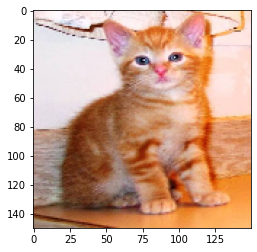

In [22]:
# Prediction
classes = ['Cat', 'Dog']

catsdogs = [test_cats, test_dogs]

true = np.random.randint(0, 2)

picked = catsdogs[true]
fnames = [os.path.join(picked, fname) for fname in os.listdir(picked)]
img_path = fnames[np.random.randint(0, 500)]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
print(x.shape)
plt.imshow(x/255)

predicted = model.predict(preprocess_input(x.reshape(1, 150, 150, 3)))

print("True: ", classes[true], "| Predicted: ", classes[int(predicted > 0.5)])